In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import AutoTokenizer
from torch.optim import Adam
import evaluate


from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

/home/coder/envs/anna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [4]:
class AutoTextDataset(Dataset):
    def __init__(self, data):
        self.tokens = data.tokens
        
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, index):
        token = eval(self.tokens[index])
        return {
            'x': torch.tensor(token[:-1]),
            'y': torch.tensor(token[1:])
        }

        
def collate_fn(batch):
    l = torch.tensor([len(item['x']) for item in batch])
    sort_ind = torch.argsort(l, descending=True)
    x = [item['x'] for item in batch]
    y = [item['y'] for item in batch]
    
    sort_x = [x[i] for i in sort_ind]
    sort_y = [y[i] for i in sort_ind]

    pad_x = pad_sequence(sort_x, batch_first=True, padding_value=50256)
    pad_y = pad_sequence(sort_y, batch_first=True, padding_value=50256)
    return {
        'lengths': [l[i] for i in sort_ind], 
        'x': pad_x, 
        'y': pad_y, 
    }

In [5]:
class GRUmodel(nn.Module):
    def __init__(self, vocab_size=50257, embed_dim=128, hidden_dim=64, padding_idx=50256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, lengths=None):
        emb = self.emb(x)
        if lengths is not None:
            packed_emb = pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
            out, _ = self.gru(packed_emb)
            out, _ = pad_packed_sequence(out, batch_first=True)
        else:
            out, _ = self.gru(emb)
        logits = self.fc(out)
        return logits

    def generate(self, context_tokens, max_new_tokens=10, temperature=1.0):
        self.eval()
        with torch.no_grad():
            generated = context_tokens.clone()

            for _ in range(max_new_tokens):
                logits = self(generated)  
                next_logits = logits[0, -1, :] / temperature 
                probs = torch.softmax(next_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)
                if next_token.item() == self.emb.padding_idx:
                    break

            return generated

In [6]:
def train_loop(dataloader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        x = batch['x'].to(device)
        y = batch['y'].to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def val_loop(dataloader, model, criterion, device, num_samples=3):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            x = batch['x'].to(device)
            y = batch['y'].to(device)

            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
trainds = AutoTextDataset(train)
valds = AutoTextDataset(val)
train_loader = DataLoader(trainds, shuffle=True, batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(valds, shuffle=False, batch_size=128, collate_fn=collate_fn)
model = GRUmodel()
device = 'cuda'
optimizer = Adam(model.parameters(), lr=5e-3)

criterion = nn.CrossEntropyLoss(ignore_index=50256)
model.to(device)
epochs = 16
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

In [8]:
train_loss_list, val_loss_list = [], []
from torch.optim.lr_scheduler import CosineAnnealingLR
sheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min = 1e-6)

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_loop(train_loader, model, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Val Loss: {val_loss:.4f}")
    
    sheduler.step()
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)


Epoch 1/16


100%|██████████| 17506/17506 [02:13<00:00, 130.95it/s]


Train Loss: 5.2459


100%|██████████| 2626/2626 [00:24<00:00, 105.96it/s]


Val Loss: 5.0368

Epoch 2/16


100%|██████████| 17506/17506 [02:13<00:00, 131.43it/s]


Train Loss: 4.9692


100%|██████████| 2626/2626 [00:24<00:00, 107.96it/s]


Val Loss: 4.9531

Epoch 3/16


100%|██████████| 17506/17506 [02:13<00:00, 131.52it/s]


Train Loss: 4.8952


100%|██████████| 2626/2626 [00:24<00:00, 108.22it/s]


Val Loss: 4.9127

Epoch 4/16


100%|██████████| 17506/17506 [02:13<00:00, 130.95it/s]


Train Loss: 4.8602


100%|██████████| 2626/2626 [00:24<00:00, 108.36it/s]


Val Loss: 4.8909

Epoch 5/16


100%|██████████| 17506/17506 [02:13<00:00, 131.48it/s]


Train Loss: 4.8227


100%|██████████| 2626/2626 [00:24<00:00, 108.34it/s]


Val Loss: 4.8704

Epoch 6/16


100%|██████████| 17506/17506 [02:13<00:00, 131.24it/s]


Train Loss: 4.8170


100%|██████████| 2626/2626 [00:24<00:00, 108.32it/s]


Val Loss: 4.8762

Epoch 7/16


100%|██████████| 17506/17506 [02:13<00:00, 131.13it/s]


Train Loss: 4.8095


100%|██████████| 2626/2626 [00:24<00:00, 108.35it/s]


Val Loss: 4.9790

Epoch 8/16


100%|██████████| 17506/17506 [02:13<00:00, 131.27it/s]


Train Loss: 4.8205


100%|██████████| 2626/2626 [00:24<00:00, 108.20it/s]


Val Loss: 4.8456

Epoch 9/16


100%|██████████| 17506/17506 [02:13<00:00, 131.33it/s]


Train Loss: 4.7440


100%|██████████| 2626/2626 [00:24<00:00, 108.36it/s]


Val Loss: 4.8070

Epoch 10/16


100%|██████████| 17506/17506 [02:13<00:00, 131.33it/s]


Train Loss: 4.7036


100%|██████████| 2626/2626 [00:24<00:00, 108.22it/s]


Val Loss: 4.7858

Epoch 11/16


100%|██████████| 17506/17506 [02:13<00:00, 131.41it/s]


Train Loss: 4.6836


100%|██████████| 2626/2626 [00:24<00:00, 108.03it/s]


Val Loss: 4.7774

Epoch 12/16


100%|██████████| 17506/17506 [02:13<00:00, 131.24it/s]


Train Loss: 4.6547


100%|██████████| 2626/2626 [00:24<00:00, 108.13it/s]


Val Loss: 4.7588

Epoch 13/16


100%|██████████| 17506/17506 [02:13<00:00, 131.18it/s]


Train Loss: 4.6304


100%|██████████| 2626/2626 [00:24<00:00, 108.10it/s]


Val Loss: 4.7490

Epoch 14/16


100%|██████████| 17506/17506 [02:13<00:00, 131.42it/s]


Train Loss: 4.6118


100%|██████████| 2626/2626 [00:24<00:00, 108.19it/s]


Val Loss: 4.7420

Epoch 15/16


100%|██████████| 17506/17506 [02:13<00:00, 131.31it/s]


Train Loss: 4.5963


100%|██████████| 2626/2626 [00:24<00:00, 108.11it/s]


Val Loss: 4.7371

Epoch 16/16


100%|██████████| 17506/17506 [02:13<00:00, 131.29it/s]


Train Loss: 4.5864


100%|██████████| 2626/2626 [00:24<00:00, 108.24it/s]

Val Loss: 4.7350


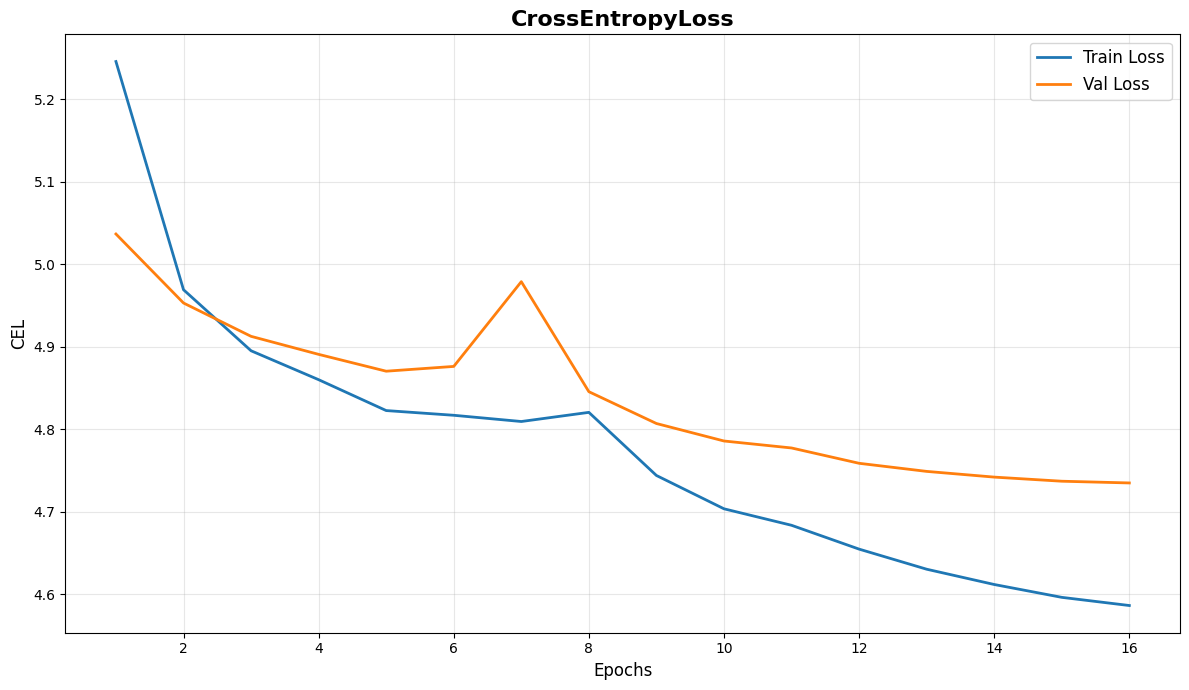

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
epochs = range(1, len(train_loss_list) + 1)


plt.plot(epochs, train_loss_list, label="Train Loss", color="tab:blue", linewidth=2)
plt.plot(epochs, val_loss_list, label="Val Loss", color="tab:orange", linewidth=2)

plt.title('CrossEntropyLoss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel("CEL", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

In [15]:
torch.save(model.state_dict(), 'gru_model_autotest.pth')